In [3]:

from pydantic_ai import Agent, RunContext
from pydantic_ai.common_tools.tavily import tavily_search_tool
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.google import GoogleModel
from pydantic_ai.providers.google import GoogleProvider
from dotenv import load_dotenv
from dataclasses import dataclass
from datetime import datetime
from pydantic import Field

from langchain_google_genai import ChatGoogleGenerativeAI
import nest_asyncio
nest_asyncio.apply()
from langchain_openai import ChatOpenAI

import os
from tavily import TavilyClient
load_dotenv()
google_api_key=os.getenv('google_api_key')
tavily_key=os.getenv('tavily_key')
pse=os.getenv('pse')
openai_api_key=os.getenv('openai_api_key')
tavily_client = TavilyClient(api_key=tavily_key)
composio_api_key=os.getenv('composio_api_key')
# configure logfire
import logfire
logfire.configure(token=os.getenv('logfire_token'))
logfire.instrument_pydantic_ai()


In [4]:

api_keys={
    'google_api_key':google_api_key,
    'tavily_key':tavily_key,
    'pse':pse,
    'openai_api_key':openai_api_key,
    'composio_key':composio_api_key
}


In [6]:


llms={'pydantic_llm':GoogleModel('gemini-2.5-flash', provider=GoogleProvider(api_key=api_keys['google_api_key'])),
              'langchain_llm':ChatGoogleGenerativeAI(google_api_key=api_keys['google_api_key'], model='gemini-2.5-flash-preview-05-20', temperature=0.3),
              'openai_llm':ChatOpenAI(model='gpt-4.1-nano',api_key=api_keys['openai_api_key'])}

In [7]:
import httpx

from pydantic_ai import Agent, BinaryContent

image_response = httpx.get('https://iili.io/3Hs4FMg.png')  # Pydantic logo

agent = Agent(llms['pydantic_llm'])
result = agent.run_sync(
    [
        'What company is this logo from?',
        BinaryContent(data=image_response.content, media_type='image/png'),  
    ]
)
print(result.output)

16:16:29.268 agent run
16:16:29.269   chat gemini-2.5-flash
This logo is from **Pydantic**.

Pydantic is a Python library primarily used for data validation and parsing using Python type hints. The tagline "Bringing schema and sanity to your data" clearly reflects its purpose.


In [4]:

class Api_keys:
    api_keys: dict


@dataclass
class Message_state:
    messages: list[ModelMessage]

@dataclass
class Deps:
    agents_output: dict
    mail_inbox: dict
    google_agent_output: dict
    
class Cortana_agent:
    def __init__(self, api_keys:dict, google_agent_api_url:str = "https://wolf1997-google-agent-api.hf.space", outlook_agent_api_url:str = "https://wolf1997-outlook-agent-api.hf.space"):
        """
        Args:
            
            api_keys (dict): The API keys to use as a dictionary
            google_agent_api_url (str): The URL of the Google Agent API
            outlook_agent_api_url (str): The URL of the Outlook Agent API
            
        """
        GEMINI_MODEL='gemini-2.0-flash'
        self.api_keys=Api_keys(api_keys=api_keys)
        self.google_agent_api_url = google_agent_api_url
        self.outlook_agent_api_url = outlook_agent_api_url
       
        # tools
        llms={'pydantic_llm':GoogleModel('gemini-2.5-flash-preview-05-20', provider=GoogleProvider(api_key=self.api_keys.api_keys['google_api_key'])),
              'langchain_llm':ChatGoogleGenerativeAI(google_api_key=self.api_keys.api_keys['google_api_key'], model=GEMINI_MODEL, temperature=0.3),
              'openai_llm':ChatOpenAI(model='gpt-4.1-nano',api_key=self.api_keys.api_keys['openai_api_key'])}
        async def google_agent_tool(ctx:RunContext[Deps],query:str):
            """
            # Google Agent Interaction Function

            ## Purpose
            This function provides an interface to interact with a Google agent that can perform multiple Google-related tasks simultaneously but it cannot do 
            websearches.

            ## Capabilities
            The agent can:
            - Search for images
            - Manage user emails
            - Manage Google tasks
            - get contact list
            - List available tools
            - Improve planning based on user feedback with planning notes
            - Improve its query based on user feedback with query notes

            ## Parameters
            - `query` (str): A complete query string describing the desired Google agent actions
            - The query should include all necessary details for the requested operations
            - Multiple actions can be specified in a single query

            ## Returns
            - `str`: The agent's response to the query

            ## Important Notes
            - The agent can process multiple actions in a single query
            - User feedback can be provided to help improve the agent's planning and query
            - All Google-related operations should be included in the query string

            """
            try:
                # Make API call to Google Agent
                data = {
                    'query': query,
                    'google_api_key': self.api_keys.api_keys['google_api_key'],
                    'openai_api_key': self.api_keys.api_keys['openai_api_key'],
                    'composio_key': self.api_keys.api_keys['composio_key'],
                    'pse': self.api_keys.api_keys.get('pse', '')
                }
                
                response = requests.post(f"{self.google_agent_api_url}/chat", data=data)
                response.raise_for_status()
                result = response.json()
                
                # Store the response in context
                ctx.deps.agents_output['google_agent_tool'] = result
                
                return result.get('response').get('node_messages_list')[-1]
            except Exception as e:
                return f"Error calling Google Agent API: {str(e)}"
        
        async def reset_google_agent_tool(ctx:RunContext[Deps]):
            """
            Use this tool to reset the google agent when it is not working as expected
            """
            try:
                response = requests.post(f"{self.google_agent_api_url}/reset")
                response.raise_for_status()
                result = response.json()
                return result.get('message', 'Google agent has been reset')
            except Exception as e:
                return f"Error resetting Google Agent: {str(e)}"

        async def outlook_agent_tool(ctx:RunContext[Deps], query:str):
            """
            # Outlook Agent Interaction Function

            ## Purpose
            This function provides an interface to interact with an Outlook agent that can perform Microsoft 365 tasks.

            ## Capabilities
            The agent can:
            - Read and manage Outlook emails
            - Create and manage Microsoft Tasks/To-Do
            - Manage Outlook Calendar events
            - Manage Outlook Contacts
            - Access Microsoft Graph API services

            ## Parameters
            - `query` (str): A complete query string describing the desired Outlook agent actions
            - The query should include all necessary details for the requested operations
            - Multiple actions can be specified in a single query

            ## Returns
            - `str`: The agent's response to the query

            ## Important Notes
            - The agent can process multiple actions in a single query
            - All Microsoft 365 operations should be included in the query string
            """
            try:
                # Make API call to Outlook Agent
                data = {
                    'query': query,
                    'google_api_key': self.api_keys.api_keys['google_api_key'],
                    'openai_api_key': self.api_keys.api_keys['openai_api_key'],
                    'composio_key': self.api_keys.api_keys['composio_key']
                }
                
                response = requests.post(f"{self.outlook_agent_api_url}/chat", data=data)
                response.raise_for_status()
                result = response.json()
                
                # Store the response in context
                ctx.deps.agents_output['outlook_agent_tool'] = result
                
                return result.get('response', str(result))
            except Exception as e:
                return f"Error calling Outlook Agent API: {str(e)}"

        async def reset_outlook_agent_tool(ctx:RunContext[Deps]):
            """
            Use this tool to reset the outlook agent when it is not working as expected
            """
            try:
                response = requests.post(f"{self.outlook_agent_api_url}/reset")
                response.raise_for_status()
                result = response.json()
                return result.get('message', 'Outlook agent has been reset')
            except Exception as e:
                return f"Error resetting Outlook Agent: {str(e)}"

        async def web_search_tool(ctx: RunContext[Deps], query:str):
            """
            Use this tool to do a quick web search on a topic, to gather informations and data.
            Args:
                query (str): The query related to the web_search_tool and its capabilities
                
            Returns:
                str: The response from the web_search_tool
            """
            quick_research_agent=Agent(llms['pydantic_llm'], tools=[tavily_search_tool(self.api_keys.api_keys['tavily_key'])], instructions="do a websearch based on the query")
            result= quick_research_agent.run_sync(query)
            ctx.deps.agents_output['web_search_tool']=result.output
            return result.output
        
        async def Memory_tool(ctx: RunContext[Deps], query:str):
            """
            Use this tool to dive into the memory of the agents to answer questions based on previous information provided from previous tool calls.
            Args:
                query (str): The query related to the Memory_tool and its capabilities
                
            Returns:
                str: The response from the Memory_tool
            """
            history=ctx.deps.agents_output

            answer_question_agent=Agent(llms['pydantic_llm'], tools=[tavily_search_tool(self.api_keys.api_keys['tavily_key'])], instructions="answer the question based on the information provided")
            result= answer_question_agent.run_sync(f"answer the question based on the information provided: {history} and the query: {query}")
            return result.output


        async def get_current_time_tool():
            """
            Use this tool to get the current time.
            Returns:
                str: The current time in a formatted string
            """
        
            return f"The current time is {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
                

        @dataclass
        class Cortana_output:
            ui_version: str= Field(description='a markdown format version of the answer for displays if necessary')
            voice_version: str = Field(description='a conversationnal version of the answer for text to voice')
        self.agent=Agent(llms['pydantic_llm'], output_type=Cortana_output, tools=[google_agent_tool, web_search_tool, Memory_tool, get_current_time_tool, reset_google_agent_tool, outlook_agent_tool, reset_outlook_agent_tool], system_prompt="you are Cortana, a helpful assistant that can help with a wide range of tasks,\
                          you can use the tools provided to you if necessary to help the user with their queries, ask how you can help the user, sometimes the user will ask you not to use the tools, in this case you should not use the tools")
        self.memory=Message_state(messages=[])
        self.deps=Deps(agents_output={}, google_agent_output={},mail_inbox={})
    
    def chat(self, query:any):
        """
        # Chat Function Documentation

        This function enables interaction with the user through various types of input.

        ## Parameters

        - `query`: The input to process. Can be one of the following types:
        - String: Direct text input passed to the agent
        - Binary content: Special format for media files (see below)

        ## Binary Content Types

        The function supports different types of media through `BinaryContent` objects:

        ### Audio
        ```python
        cortana_agent.chat([
            'optional string message',
            BinaryContent(data=audio, media_type='audio/wav')
        ])
        ```

        ### PDF Files
        ```python
        cortana_agent.chat([
            'optional string message',
            BinaryContent(data=pdf_path.read_bytes(), media_type='application/pdf')
        ])
        ```

        ### Images
        ```python
        cortana_agent.chat([
            'optional string message',
            BinaryContent(data=image_response.content, media_type='image/png')
        ])
        ```

        ## Returns

        - `Cortana_output`: as a pydantic object, the ui_version and voice_version are the two fields of the object

        ## Extra Notes
        The deps and message_history of cortana can be accessed using the following code:
        ```python
        cortana_agent.deps
        cortana_agent.memory.messages
        ```
        """

        result=self.agent.run_sync(query, deps=self.deps, message_history=self.memory.messages)
        self.memory.messages=result.all_messages()
        return result.output
    def reset(self):
        """
        Resets the Cortana agent to its initial state.

        Returns:
            str: A confirmation message indicating that the agent has been reset.
        """
        self.memory.messages=[]
        self.deps=Deps(agents_output={}, google_agent_output={},mail_inbox={})
        return f'Cortana has been reset'


In [5]:
llms={'pydantic_llm':GoogleModel('gemini-2.5-flash-preview-05-20', provider=GoogleProvider(api_key=api_keys['google_api_key'])),
              'langchain_llm':ChatGoogleGenerativeAI(google_api_key=api_keys['google_api_key'], model='gemini-2.0-flash', temperature=0.3),
              'openai_llm':ChatOpenAI(api_key=api_keys['openai_api_key'])}

In [6]:
google_agent=Google_agent(llms,api_keys)

c:\Users\trist\OneDrive\Desktop\important\ai_portfolio\Cortana\.venv\Lib\site-packages\composio\client\collections.py:1183: UserWarning: Using all actions of an app is not recommended for production.Learn more: https://docs.composio.dev/patterns/tools/use-tools/use-specific-actions

Give Feedback / Get Help:
    On GitHub: https://github.com/ComposioHQ/composio/issues/new
    On Discord: https://dub.composio.dev/discord
    On Email: tech@composio.dev
    Talk to us on Intercom: https://composio.dev
    Book a call with us: https://composio.dev/redirect?url=https://calendly.com/composiohq/support?utm_source=py-sdk-logs&utm_campaign=calendly
If you need to debug this error, set `COMPOSIO_LOGGING_LEVEL=debug`.
  warnings.warn(
c:\Users\trist\OneDrive\Desktop\important\ai_portfolio\Cortana\.venv\Lib\site-packages\composio\client\collections.py:1183: UserWarning: Using all actions of an app is not recommended for production.Learn more: https://docs.composio.dev/patterns/tools/use-tools/use

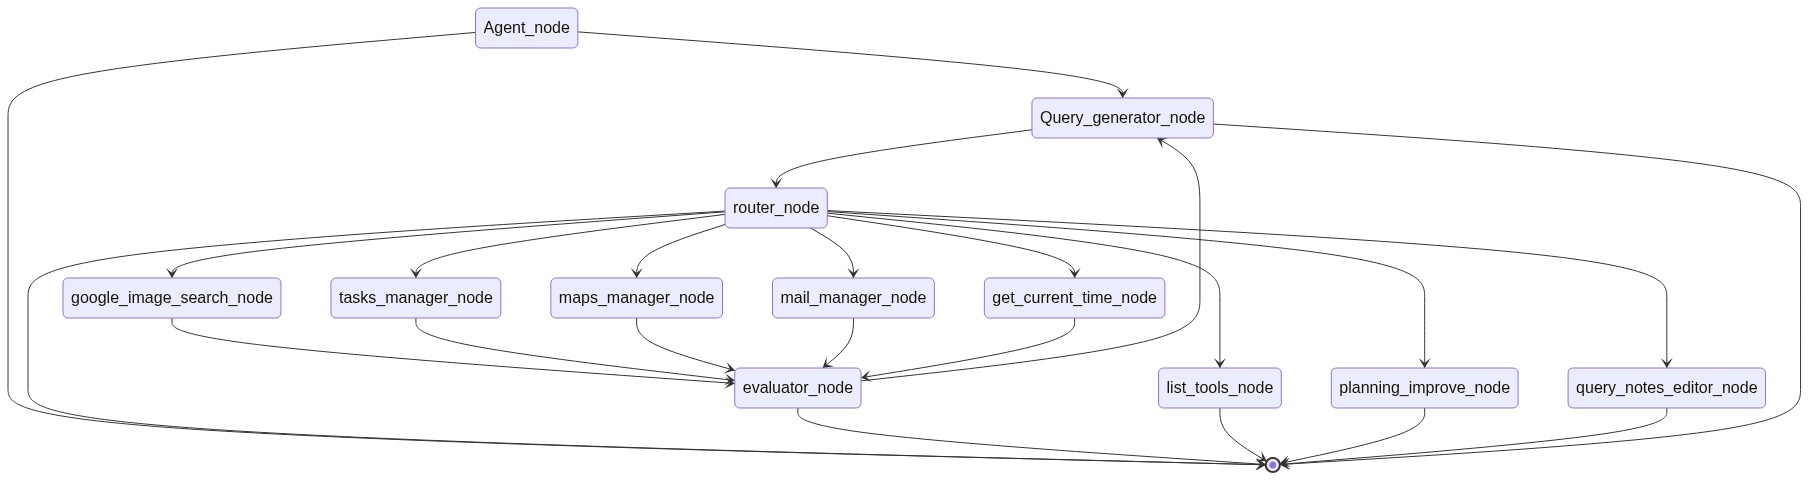

In [7]:
google_agent.display_graph()

In [9]:
cortana_agent=Cortana_agent(api_keys)

c:\Users\trist\OneDrive\Desktop\important\ai_portfolio\Cortana\.venv\Lib\site-packages\composio\client\collections.py:1183: UserWarning: Using all actions of an app is not recommended for production.Learn more: https://docs.composio.dev/patterns/tools/use-tools/use-specific-actions


  warnings.warn(


In [10]:
res=cortana_agent.chat('search nice restaurants in east village nyc and pictures of the places and send the list of places with the pictures to padioutristan@gmail.com')
print(res.ui_version)

22:50:48.973 agent run
22:50:48.975   chat gemini-2.5-flash-preview-05-20
22:50:50.935   running 1 tool
22:50:50.935     running tool: google_agent_tool
22:50:50.963       run graph None
22:50:50.968         run node Agent_node
22:50:50.971           plan_agent run
22:50:50.971             chat gemini-2.5-flash-preview-05-20
22:50:55.237         run node Query_generator_node
22:50:55.240           agent run
22:50:55.241             chat gemini-2.5-flash-preview-05-20
22:50:56.046         run node router_node
22:50:56.047         run node maps_manager_node
22:50:59.200         run node evaluator_node
22:50:59.203           evaluator_agent run
22:50:59.204             chat gemini-2.5-flash-preview-05-20
22:51:00.777         run node Query_generator_node
22:51:00.781           agent run
22:51:00.781             chat gemini-2.5-flash-preview-05-20
22:51:02.140         run node router_node
22:51:02.141         run node google_image_search_node
22:51:02.594         run node evaluator_node
22

In [21]:
# print(res.voice_version)

In [11]:
cortana_agent.deps.google_agent_output

State(node_messages=[{'mail_manager': {'data': {'response_data': {'id': '1971dc0a2d3647e4', 'labelIds': ['UNREAD', 'SENT', 'INBOX'], 'threadId': '1971dc0a2d3647e4'}}, 'error': None, 'successfull': True, 'successful': True, 'logId': 'log_9mgcVY4--dwX'}}], evaluator_message='', query="send an email to padioutristan@gmail.com with the subject 'Nice Bars in East Village NYC' and the following body: Here are a few nice bars in the East Village, NYC: The Belfry: A stylishly decorated bar with live music, great cocktails, and good local beers on tap. They also have a happy hour. Death & Company: An award-winning cocktail bar with a speakeasy vibe. They are known for their exceptional cocktails and have been voted Best American Cocktail Bar. Reservations are not accepted, so you'll need to put your name on a list. Schmuck: This bar offers a relaxed, living-room-like atmosphere and quickly established itself as an excellent place for cocktails. The Grayson: A popular sports bar in the East Vill

In [25]:
# cortana_agent.memory.messages